# Spectral Embedding Methods

One of the primary embedding tools we'll use in this book is called *adjacency spectral embedding* {cite:t}`spectraltutorial`. You'll see spectral embedding and variations on it repeatedly, both throughout this section and when we get into applications, so it's worth taking the time to understand spectral embedding deeply. If you're familiar with Principal Component Analysis (PCA), this method has a lot of spiritual similarities. We'll need to get into a bit of linear algebra to understand how it works.

The basic idea behind Spectral Embedding is to take a network, optionally take its Laplacian, and then find the eigenvectors corresponding to the $d$ largest eigenvalues, depending on how many dimensions ($d$) you'd like to embed your network down to. The new matrix will be organized traditionally, with rows (observations) corresponding to nodes, and columns (features) corresponding to the top eigenvectors of the network. A few concepts come into play here. If you're using Laplacian Spectral Embedding instead of Adjacency Spectral Embedding, you'll need to generate the Laplacian. Then, in either case, you'll need to figure out how to find our matrix's eigenvectors, and you'll need to understand how you can use those eigenvectors to represent nodes in Euclidean space. 

Let's start with a simple network. We'll take its Laplacian, just to show what that optional step looks like, and then we'll find its eigenvectors. Along the way, we'll learn about Singular Value Decomposition.

*notes* (TODO: remove)
- if L has eigenvalue 0 with k different eigenvectors, such that $o = \lambda_1 = \dots = \lambda_k$, graph G has k connected components
- if G is connected, $\lambda_2$ is the algebraic connectivity of G.

## A Simple Network

Let's say we have the simple network below. There are six nodes total, numbered 0 through 5, and there are two distinct connected groups (called "connected components" in network theory land). Nodes 0 through 2 are all connected to each other, and nodes 3 through 5 are also all connected to each other. 

In [13]:
from itertools import combinations
import numpy as np

def add_edge(A, edge: tuple):
    """
    Add an edge to an undirected graph.
    """
    i, j = edge
    A[i, j] = 1
    A[j, i] = 1
    return A

A = np.zeros((6, 6))

for edge in combinations([0, 1, 2], 2):
    add_edge(A, edge)
    
for edge in combinations([3, 4, 5], 2):
    add_edge(A, edge)

You can see the adjacency matrix and network below. Notice that there are two distrinct blocks in the adjacency matrix: in its upper-left, you can see the edges between the first three nodes, and in the bottom right, you can see the edges between the second three nodes.

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

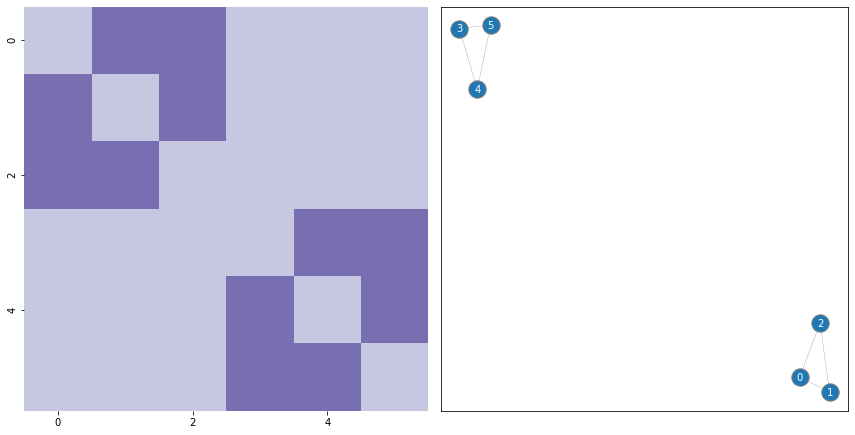

In [20]:
from graphbook_code import draw_multiplot

draw_multiplot(A, pos=nx.kamada_kawai_layout)

## The Laplacian Matrix

With spectral embedding, we'll either find the eigenvectors of the Laplacian or the eigenvectors of the Adjacency Matrix itself. Since we already have the adjacency matrix, let's take the Laplacian just to see what that looks like.

Remember from chapter four that there are a few different types of Laplacian matrices. By default, Graspologic uses the normalized Laplacian $L = I - D^{-1/2} A D^{-1/2}$, but for simplicity, we'll just use the basic, cookie-cutter version of the Laplacian $L = D - A$.

In [132]:
# Build the degree matrix D
degrees = np.count_nonzero(A, axis=0)
D = np.diag(degrees)
D

array([[2, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 2]])

In [133]:
# Build the Laplacian matrix L
L = D-A
L

array([[ 2., -1., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.],
       [-1., -1.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2., -1., -1.],
       [ 0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1., -1.,  2.]])

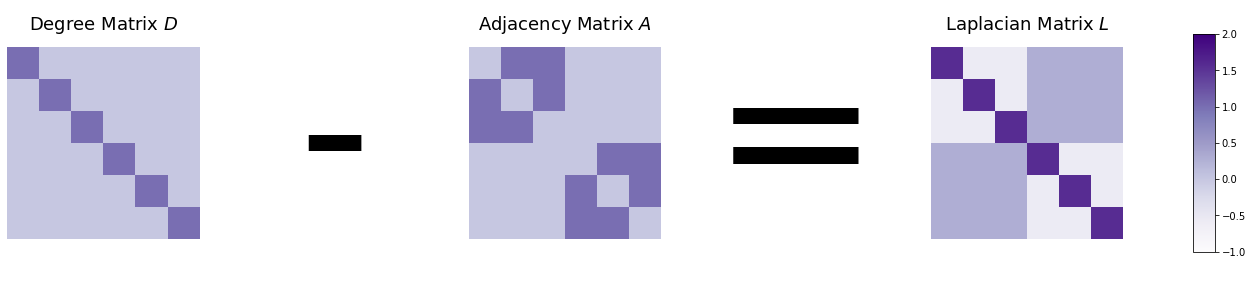

In [130]:
from graphbook_code import heatmap
import seaborn as sns
from matplotlib.colors import Normalize
from graphbook_code import GraphColormap
import matplotlib.cm as cm

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# First axis (Degree)
heatmap(D, ax=axs[0], cbar=False, title="Degree Matrix $D$")

# Second axis (-)
axs[1].text(x=.5, y=.5, s="-", fontsize=200, 
            va='center', ha='center')
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
sns.despine(ax=axs[1], left=True, bottom=True)

# Third axis (Adjacency matrix)
heatmap(A, ax=axs[2], cbar=False, title="Adjacency Matrix $A$")

# Third axis (=)
axs[3].text(x=.5, y=.5, s="=", fontsize=200,
            va='center', ha='center')
axs[3].get_xaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)
sns.despine(ax=axs[3], left=True, bottom=True)

# Fourth axis
heatmap(L, ax=axs[4], cbar=False, title="Laplacian Matrix $L$")

# Colorbar
vmin, vmax = np.array(L).min(), np.array(L).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, ax=axs, shrink=0.8, aspect=10);

## Finding Eigenvectors: Singular Value Decomposition

Now that we have a Laplacian matrix, we'll want to find its eigenvectors - or, more generally, its "singular vectors". To do this, we'll need to use a technique called *Singular Value Decomposition*, or SVD. 

SVD is a way to break a single matrix apart into three submatrices -- In our case, the matrix will be the Laplacian we just built. Generally, these three submatrices correspond to something called the singular vectors and singular values. These are general versions of eigenvectors and eigenvalues: all matrices have a full set of singular vectors/values, but not all matrices have a full set of eigenvectors/values. In the case of the Laplacian (as with all symmetric matrices that have positive eigenvalues), it turns out that the singular vectors/values and the eigenvectors/values are the same thing. For more technical details on how SVD works, or for explicit proofs, we would recommend a Linear Algebra textbook [Trefethan, LADR]. Let's look at the SVD with a bit more detail. This description of the SVD only applies to square, symmetric matrices, but you can use the SVD on any matrix with a bit more generality.

**Singular Value Decomposition** Suppose you have a square, symmetrix matrix $X$. In our case, $X$ corresponds to the Laplacian $L$ (or the adjacency matrix $A$).

\begin{align*}
\begin{bmatrix}
    X_{11} & & & " \\
    & X_{22} & & \\
    & & \ddots & \\
    " & & & X_{nn}
    \end{bmatrix}
\end{align*}

Then, you can find three matrices - one which rotates vectors in space, one which scales them along each coordinate axis, and another which rotates them back - which, when you multiply them all together, create $X$. This is the essence of Singular Value Decomposition: you can break down any linear transformation into a rotation, a scaling, and another rotation. Let's call the matrix which rotates $U$, and the matrix that scales $\Sigma$.

\begin{align*}
    X &= U \Sigma U^T
\end{align*}

Since $U$ is a rotation matrix, all of its column-vectors are at ninety-degree angles from each other and they all have the unit length of 1. These columns are called the **singular vectors** of X. Since $\Sigma$ just scales, it's a diagonal matrix: there are values on the diagonals, but nothing on the off-diagonals. The amount that each coordinate axis is scaled are the values on the diagonal entries of $\Sigma$, $\sigma_{ii}$. These are the **singular values** of the matrix $X$, and again, if they're all positive (and if X is symmetric), they'll also be X's eigenvalues. This will be the case with both the Laplacian and the adjacency matrix, assuming our network is undirected.

\begin{align*}
    X &= \begin{bmatrix}
    \uparrow & \uparrow &  & \uparrow \\
    u_1 & \vec u_2 & ... & \vec u_n \\
    \downarrow & \downarrow &  & \downarrow
    \end{bmatrix}\begin{bmatrix}
    \sigma_1 & &  & \\
    & \sigma_2 &  & \\
    & & \ddots & \\
    & & & \sigma_n
    \end{bmatrix}\begin{bmatrix}
    \leftarrow & \vec u_1^T & \rightarrow \\
    \leftarrow & \vec u_2^T & \rightarrow \\
    & \vdots & \\
    \leftarrow & \vec u_n^T & \rightarrow \\
    \end{bmatrix}
\end{align*}
Let's illustrate the SVD using an example. We will sample a $50 \times 50$ realization of an adjacency matrix from a random network which is an *a priori* SBM, with $2$ communities. The first 25 nodes will be in the first coommunity, and the second 25 nodes will be in the second community. The within-community probabilities will both be $0.8$, and the between-community probabilities will be $0.1$: